# SAR example
Let's use EOReader with SAR data.

<div class="alert alert-warning">
  
<strong>Warning:</strong> SAR data is processed with <a href="https://step.esa.int/main/download/snap-download/">SNAP</a>, so be sure to have it installed and that <code>GPT</code> is in your path. 
    
</div>


## Imports

In [1]:
import os
import matplotlib.pyplot as plt

# EOReader
from eoreader.reader import Reader
from eoreader.bands import VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE, to_str
from eoreader.env_vars import DEM_PATH

## Create logger

In [2]:
# Create logger
import logging
from sertit import logs

logger = logging.getLogger("eoreader")
logs.init_logger(logger)

## Open the Capella product

Please be aware that:
- **EOReader** will orthorectify your SAR data to get UTM tiles.
- complex data is not handled as is, **EOReader** will convert them to ground range.

In [3]:
# First of all, we need some VHR data, let's use some CAPELLA data
path = os.path.join("/home", "prods", "CAPELLA", "CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020")

# Open your product
prod = Reader().open(path, remove_tmp=True)
prod

eoreader.CapellaProduct 'CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020'
Attributes:
	condensed_name: 20210926T061012_CAPELLA_HH_SS_SLC
	path: /home/prods/CAPELLA/CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020
	constellation: Capella
	sensor type: SAR
	product type: SLC
	default pixel size: 0.6
	default resolution: 1.0
	acquisition datetime: 2021-09-26T06:10:12
	band mapping:
		HH: HH
		HH_DSPK: HH_DSPK
	needs extraction: True
	orbit direction: ASCENDING

/opt/conda/lib/python3.11/site-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


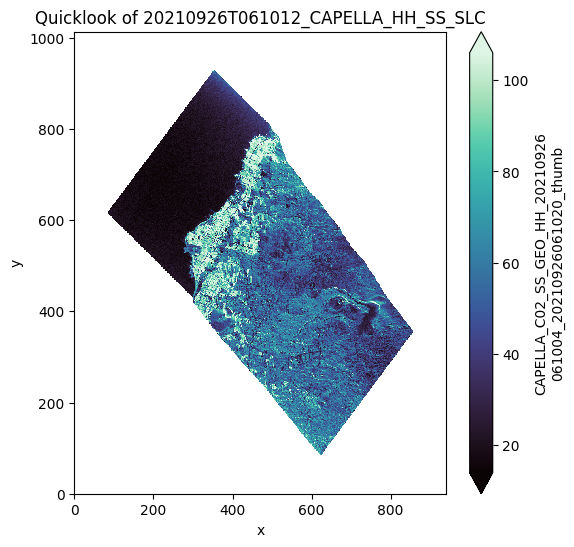

In [4]:
# Plot the quicklook
# The quicklook is not georeferenced and will apprear twicked
prod.plot(nodata=0)

In [5]:
# Get the band information
prod.bands

eoreader.SarBand 'HH'
Attributes:
	id: HH
	eoreader_name: HH
	gsd (m): 0.6
	asset_role: intensity
eoreader.SarBand 'HH_DSPK'
Attributes:
	id: HH_DSPK
	eoreader_name: HH_DSPK
	gsd (m): 0.6
	asset_role: intensity

Acquisition datetime: 2021-09-26 06:10:12
Condensed name: 20210926T061012_CAPELLA_HH_SS_SLC


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
SEVERE: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Failed to scan /opt/esa-snap/opttbx [reason: /opt/esa-snap/opttbx]
2025-12-23 09:52:01,358 - [DEBUG] - Pre-process SAR image


SNAP Release version 13.0.0
SNAP home: /opt/esa-snap/bin/..
SNAP debug: null
SNAP log level: WARNING
Java home: /opt/esa-snap/jre
Java version: 21.0.6
Processors: 16
Max memory: 29.0 GB
Cache size: 14.0 GB
Tile parallelism: 14
Tile size: 512 x 512 pixels

To configure your gpt memory usage:
Edit snap/bin/gpt.vmoptions

To configure your gpt cache size and parallelism:
Edit .snap/etc/snap.properties or gpt -c ${cachesize-in-GB}G -q ${parallelism} 


SLF4J: Failed to load class "org.slf4j.impl.StaticLoggerBinder".
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See http://www.slf4j.org/codes.html#StaticLoggerBinder for further details.
SEVERE: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Failed to scan /opt/esa-snap/opttbx [reason: /opt/esa-snap/opttbx]


Executing processing graph
....10%....20%....30%....40%....50%....60%....70%....80%....90%

2025-12-23 09:52:18,038 - [DEBUG] - Converting DIMAP to GeoTiff
2025-12-23 09:52:18,039 - [DEBUG] - Write SAR
2025-12-23 09:52:18,040 - [DEBUG] - Found [PosixPath('/tmp/tmpwcp8tciv/20210926T061012_CAPELLA_HH_SS_SLC.data/Sigma0_HH_db.img')] sub-images (for HH).


 done.


2025-12-23 09:52:19,429 - [DEBUG] - SAR predictor: 3 (SNAP version: 13.0.0)
'_vectorize' function is not lazy yet. Computing the raster.


<Axes: >

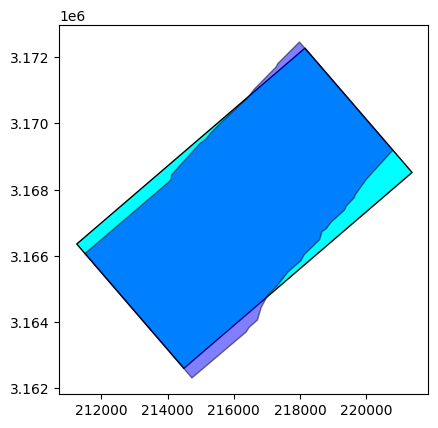

/opt/conda/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [6]:
# Print some data
print(f"Acquisition datetime: {prod.datetime}")
print(f"Condensed name: {prod.condensed_name}")

# Open here some more interesting geographical data: extent and footprint
extent = prod.extent()
footprint = prod.footprint()

base = extent.plot(color='cyan', edgecolor='black')
footprint.plot(ax=base, color='blue', edgecolor='black', alpha=0.5)

For SAR data, the footprint needs the orthorectified data !
For that, SNAP uses its own DEM, but you can change it when positionning the `EOREADER_SNAP_DEM_NAME` environment variable. 
Available DEMs are:
- `ACE2_5Min` 
- `ACE30`
- `ASTER 1sec GDEM`
- `Copernicus 30m Global DEM`
- `Copernicus 90m Global DEM`
- `GETASSE30`
- `SRTM 1Sec HGT`
- `SRTM 3Sec`
- `External DEM`

<div class="alert alert-warning">
  
<strong>Warning:</strong> 
   If `External DEM` is set, you must specify the DEM you want by positioning the `EOREADER_DEM_PATH` to a DEM that can be read by SNAP.
</div>
    
## Load bands

In [7]:
# Set the DEM
os.environ[DEM_PATH] = os.path.join("/home", "ds2_db2", "BASES_DE_DONNEES", "GLOBAL", "COPDEM_30m", "COPDEM_30m.vrt")

# Select some bands you wish to load without knowing if they exist
bands = [VV, HH, VV_DSPK, HH_DSPK, HILLSHADE, SLOPE]

# Only keep those selected
ok_bands = [band for band in bands if prod.has_band(band)]

# This product does not have VV band and HILLSHADE band cannot be computed from SAR band
print(to_str(ok_bands))

['HH', 'HH_DSPK', 'SLOPE']


In [8]:
# Load those bands as a xarray.Dataset, with a 5 m pixel size
band_ds = prod.load(ok_bands, pixel_size=5.)
band_ds[HH]

2025-12-23 09:52:21,464 - [DEBUG] - Loading bands ['HH', 'HH_DSPK']
2025-12-23 09:52:21,465 - [DEBUG] - Deriving HH at 5.0 m from 20210926T061012_CAPELLA_HH_SS_SLC_HH_0-6m.
2025-12-23 09:52:21,466 - [DEBUG] - Deriving HH at 5.0 m from 20210926T061012_CAPELLA_HH_SS_SLC_HH_0-6m.
2025-12-23 09:52:21,467 - [DEBUG] - Deriving HH at 5.0 m from 20210926T061012_CAPELLA_HH_SS_SLC_HH_0-6m.
2025-12-23 09:52:21,489 - [DEBUG] - SAR predictor: 3 (SNAP version: 13.0.0)
2025-12-23 09:52:23,011 - [DEBUG] - SAR predictor: 3 (SNAP version: 13.0.0)
2025-12-23 09:52:24,653 - [DEBUG] - Loading DEM bands ['SLOPE']
2025-12-23 09:52:24,654 - [DEBUG] - Warping DEM for 20210926T061012_CAPELLA_HH_SS_SLC
2025-12-23 09:52:24,655 - [DEBUG] - Using DEM: /home/ds2_db2/BASES_DE_DONNEES/GLOBAL/COPDEM_30m/COPDEM_30m.vrt
2025-12-23 09:52:27,699 - [DEBUG] - Computing slope for 20210926T061012_CAPELLA_HH_SS_SLC


<xarray.DataArray <SarBandNames.HH: 'HH'> (band: 1, y: 2090, x: 1891)> Size: 16MB
dask.array<where, shape=(1, 2090, 1891), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 17kB 3.173e+06 3.173e+06 ... 3.162e+06 3.162e+06
  * x            (x) float64 15kB 2.114e+05 2.114e+05 ... 2.209e+05 2.209e+05
    spatial_ref  int32 4B 32628
  * band         (band) int64 8B 1
Attributes:
    path:              /tmp/tmpkzet1vdi/tmp_20210926T061012_CAPELLA_HH_SS_SLC...
    long_name:         HH
    constellation:     Capella
    constellation_id:  CAPELLA
    product_path:      /home/prods/CAPELLA/CAPELLA_C02_SS_SLC_HH_202109260610...
    product_name:      CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020
    product_filename:  CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020
    instrument:        SAR X-band
    product_type:      SLC
    acquisition_date:  20210926T061012
    condensed_name:    20210926T061012_CAPELLA_HH_SS_SLC
    orbit_direction:   ASCENDING

<div class="alert alert-info">
Some SAR band (i.e. COSMO) may contain null pixels that are not really nodata (but very low values like water).  
    
This can lead the <code>Terrain Correction</code> step to create large nodata area when projecting on a DEM.
    
If it happens, you can set the keyword <code>SAR_INTERP_NA</code> to <code>True</code> when loading or stacking SAR data to fill these area with interpolated data.
</div>

```python
from eoreader.keywords import SAR_INTERP_NA
band_dict = prod.load(
    ok_bands, 
    pixel_size=20.,
    **{SAR_INTERP_NA: True}
)
```

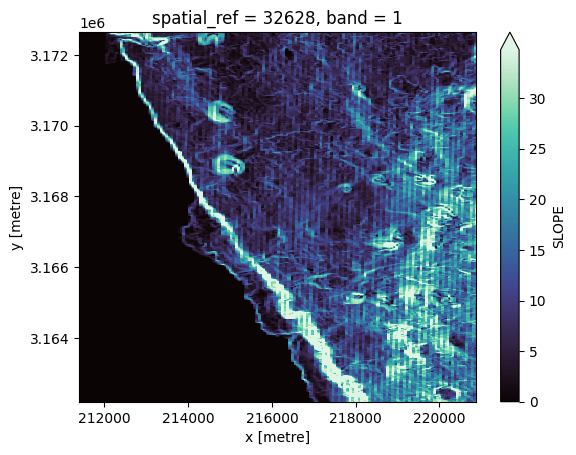

In [9]:
# Plot a subsampled version of the SLOPE band
band_ds[SLOPE][:, ::5, ::5].plot(robust=True, cmap="mako")

## Stack some data

In [10]:
# You can also stack those bands, with a 5 m pixel size
stack = prod.stack(ok_bands, pixel_size=5.)
stack

2025-12-23 09:52:36,026 - [DEBUG] - Loading bands ['HH', 'HH_DSPK']
2025-12-23 09:52:36,060 - [DEBUG] - Loading DEM bands ['SLOPE']
2025-12-23 09:52:36,060 - [INFO] - Already existing DEM for /tmp/tmpkzet1vdi/tmp_20210926T061012_CAPELLA_HH_SS_SLC/20210926T061012_CAPELLA_HH_SS_SLC_DEM_COPDEM_30m.vrt. Skipping process.
2025-12-23 09:52:36,062 - [DEBUG] - Already existing slope DEM for 20210926T061012_CAPELLA_HH_SS_SLC. Skipping process.
2025-12-23 09:52:36,090 - [DEBUG] - Stacking


<xarray.DataArray 'HH_HH_DSPK_SLOPE' (bands: 3, y: 2090, x: 1891)> Size: 47MB
dask.array<where, shape=(3, 2090, 1891), dtype=float32, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 15kB 2.114e+05 2.114e+05 ... 2.209e+05 2.209e+05
  * y            (y) float64 17kB 3.173e+06 3.173e+06 ... 3.162e+06 3.162e+06
    spatial_ref  int64 8B 0
  * bands        (bands) object 24B MultiIndex
  * variable     (bands) object 24B SarBandNames.HH ... DemBandNames.SLOPE
  * band         (bands) int64 24B 1 1 1
Attributes:
    path:              /tmp/tmpkzet1vdi/tmp_20210926T061012_CAPELLA_HH_SS_SLC...
    long_name:         HH HH_DSPK SLOPE
    constellation:     Capella
    constellation_id:  CAPELLA
    product_path:      /home/prods/CAPELLA/CAPELLA_C02_SS_SLC_HH_202109260610...
    product_name:      CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020
    product_filename:  CAPELLA_C02_SS_SLC_HH_20210926061004_20210926061020
    instrument:        SAR X-band
    product_type:      SLC
    acquisition_date:  20210926T061012
    condensed_name:    20210926T061012_CAPELLA_HH_SS_SLC
    orbit_direction:   ASCENDING

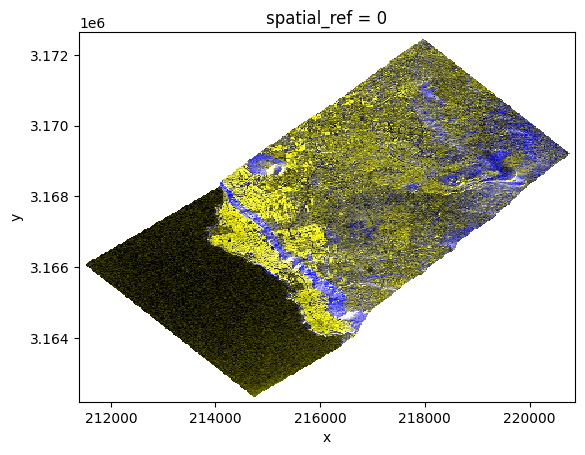

In [11]:
# Plot a subsampled version of the stack
from sertit import display
display_stack = stack[:, ::5, ::5]
display_stack.copy(data=display.scale(display_stack.data)).plot.imshow(robust=True);